# Human Activity Recognition 

In this notebook, we will consider how to apply signal processing techniques in classification tasks. The problem that we are going to tackle is about classifying the activity of someone based on raw sensor signals (accelerometer and gyroscope). 

The [dataset used](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones) is available on UCL Machine Learning Repository and it's a comprehensive dataset built from smartphone accelerometer and gyroscope sensors. This dataset contain measurements done by 30 people between ages of 19 to 48. The measurements are done with a smartphone placed on the waist while doing one of the following six activities:
- Walking
- Walking Upstairs
- Walking Downstairs
- Sitting
- Standing 
- Laying 

The measurements have been collected at a constant rate of 50 Hz and they have been pre-processed by applying noise filters. After that, the signals have been cut in fixed-width windows of 2.56 sec with 50% overlap, that's for collecting more data and to prevent missing any important events. Each signal will therefore have 50 x 2.56 = 128 samples in total. 

The smartphone measures three-axial linear body acceleration, three-axial linear gravitational acceleration and three-axial angular velocity. So, per measurement, the total signal consists of nine components.

## Import Statements 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from collections import Counter
from scipy.signal import welch
from detecta import detect_peaks 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import warnings 
warnings.filterwarnings("ignore")

## Loading the Signals 

In [2]:
# From the README.txt file 
activities_description = {
    1:"walking",
    2:"Walking upstairs",
    3:"walking downstairs",
    4:"sitting",
    5:"standing",
    6:"laying"
}

def read_signal(filename):
    with open(filename,"r") as file:
        data = file.read().splitlines()   
        data = map(lambda x: x.strip().split(),data) # splitting a signal into its samples
        data = [list(map(float,line)) for line in data] # converting str to float
    return data 

def read_labels(filename):
    with open(filename,"r") as file:
        activities = file.read().splitlines()
        activities = list(map(int,activities))
    return activities        

# the reason for using this is the train and test data are already separated. So, we need to just shuffle them 
def randomize(dataset,labels):
    permutation = np.random.permutation(len(dataset))
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

In [3]:
INPUT_FOLDER_TRAIN = "train_data/Inertial Signals/"
INPUT_FOLDER_TEST = "test_data/Inertial Signals/"

INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

LABEL_TRAIN = "train_data/y_train.txt"
LABEL_TEST = "test_data/y_test.txt"

train_signals, test_signals = list(),list()

for input_file in INPUT_FILES_TRAIN:
    signal = read_signal(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals),(1,2,0)) # the way of transposing (signals, samples of signal, components of signal)

for input_file in INPUT_FILES_TEST:
    signal = read_signal(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals),(1,2,0)) 

train_labels = np.array(read_labels(LABEL_TRAIN))
test_labels = np.array(read_labels(LABEL_TEST))

no_signals_train, no_steps_train, no_components_train = train_signals.shape
no_signals_test, no_steps_test, no_components_test = test_signals.shape
no_labels = len(set(train_labels))

print(f"The train dataset contains {no_signals_train} signals, each one of length {no_steps_train} and {no_components_train} components ")
print("--------------------------------------------------------------------------------------------")
print(f"The test dataset contains {no_signals_test} signals, each one of length {no_steps_test} and {no_components_test} components ")
print("--------------------------------------------------------------------------------------------")
print(f"The train dataset contains {len(train_labels)} labels, with the following distribution:\n {dict(sorted(Counter(train_labels).items()))}")
print("--------------------------------------------------------------------------------------------")
print(f"The test dataset contains {len(test_labels)} labels, with the following distribution:\n {dict(sorted(Counter(test_labels).items()))}")

np.random.seed(1)
train_signals,train_labels = randomize(train_signals,train_labels)
test_signals,test_labels = randomize(test_signals,test_labels)

The train dataset contains 7352 signals, each one of length 128 and 9 components 
--------------------------------------------------------------------------------------------
The test dataset contains 2947 signals, each one of length 128 and 9 components 
--------------------------------------------------------------------------------------------
The train dataset contains 7352 labels, with the following distribution:
 {1: 1226, 2: 1073, 3: 986, 4: 1286, 5: 1374, 6: 1407}
--------------------------------------------------------------------------------------------
The test dataset contains 2947 labels, with the following distribution:
 {1: 496, 2: 471, 3: 420, 4: 491, 5: 532, 6: 537}


From above, we can see that there is a class balance in the train dataset  

To get a sense of the way by which the features are extracted from the signals, i will provide some visualization about FFT, PSD and autocorrelation that illustrate such approach. 

In [4]:
# parameters that describe the discrete signals 
N = 128 # number of samples for each signal
f_s = 50 # sampling frequency 
t_n = 2.56 # interval of recording the signal 
T = t_n / N # sampling interval 

In [5]:
# the signal of case study 
signal_no = 15 
signals = train_signals[signal_no,:,:]
signal = signals[:,0] # the body linear acceleration in x-direction signal
label = train_labels[signal_no] 
activity_name = activities_description[label]
activity_name

'sitting'

In [6]:
def get_values(signal,T,N,f_s):
    """Compute the tick values corresponding to the given sampled data y_values. 

        args:
            y_values: sampled values of the signal
            T: sampling interval 
            N: number of samples
            f_s: sampling frequency  

        return: 
            x_values: tick values of sampled signal
    """
    x_values = [T * i for i in range(len(signal))]
    return x_values, signal

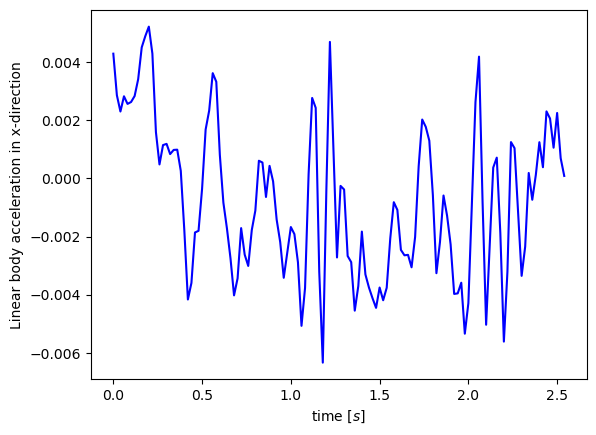

In [7]:
plt.plot(*get_values(signal,T,N,f_s),"b-")
plt.xlabel("time $[s]$")
plt.ylabel("Linear body acceleration in x-direction");

## Transformations Used in Feature Extraction 

### Fast Fourier Transform (FFT)

In [8]:
def get_fft_values(signal,T,N,f_s):
    """Compute FFT of the sampled data besides the corresponding frequency values (0 --> Nyquist frequency)
    Nyquist frequency is is the highest possible frequency can be captured from a sampled signal, which 
    is equal to (f_s/2).

        args: 
            signal: sampled values of the signal
            T: sampling interval 
            N: number of samples
            f_s: sampling frequency  

        return:
            f_values: corresponding frequency values 
            fft_values: amplitude of each sinusoid at each frequency

        """
    f_values = np.linspace(0.0,1.0/(2.0*T),N//2) 
    # we have considered half of the sampled data points due to symmetry nature of FFT    
    fft_values = np.fft.fft(signal,N) # complex coefficients of fft 
    fft_values = (2/N) * np.abs(fft_values[:N//2])
    return f_values, fft_values 

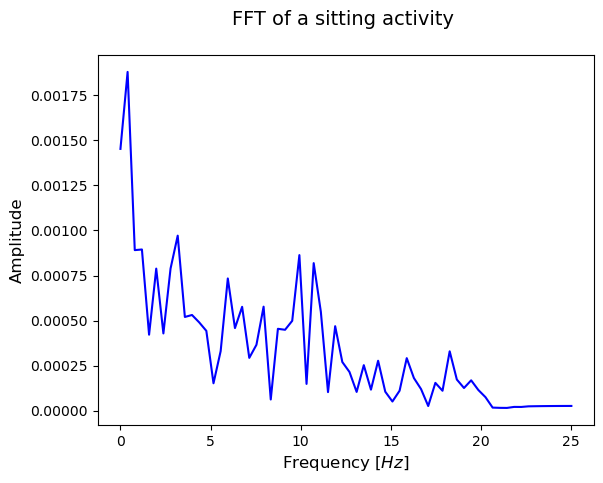

In [9]:
f_values, fft_values = get_fft_values(signal,T,N,f_s)

plt.plot(f_values,fft_values,"b-")
plt.xlabel('Frequency $[Hz]$', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.title(f"FFT of a {activity_name} activity \n ", fontsize=14);

Using  `detect_peaks()` function we can detect peaks from `fft_values` and use their coordinates as features to that signal.  
 \
In addition, we can enforce some conditions of the nature of peaks detected by the function using `mpd` (minimum peak distance), `mph` (minimum peak height), `threshold` (threshold in relation to their immediate neighbors) & `edge` (type of edge) parameters.

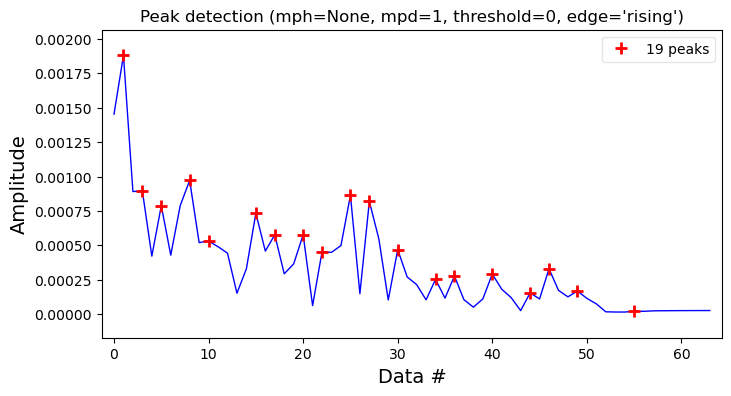

In [10]:
ind = detect_peaks(fft_values,show=True); 

### Power Spectral Density (PSD)

In [11]:
def get_psd_values(signal,T,N,f_s):
    """Computes the power spectral density of the signal using Welch's method, which is an
    improvement on the standard periodogram spectrum estimating method. 

        args: 
            signal: sampled values of the signal
            T: sampling interval 
            N: number of samples
            f_s: sampling frequency  

        return:
            f_values: corresponding frequency values 
            psd_values: The power distributed over the signal for each frequency.   
             
    """
    f_values, psd_values = welch(signal,fs = f_s) 
    return f_values, psd_values

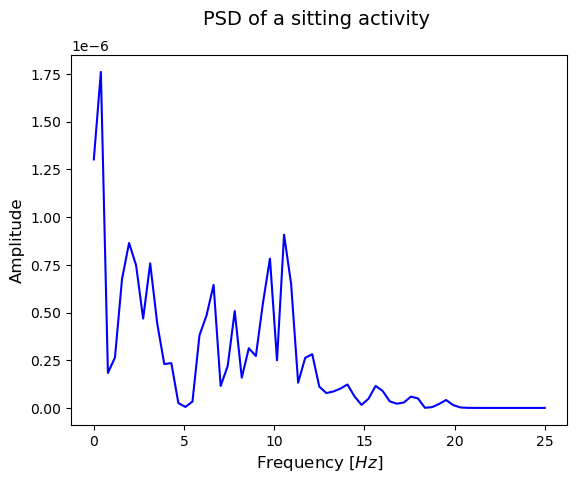

In [12]:
f_values, psd_values = get_psd_values(signal,T,N,f_s)

plt.plot(f_values,psd_values,"b-")
plt.xlabel('Frequency $[Hz]$', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.title(f"PSD of a {activity_name} activity \n", fontsize=14);

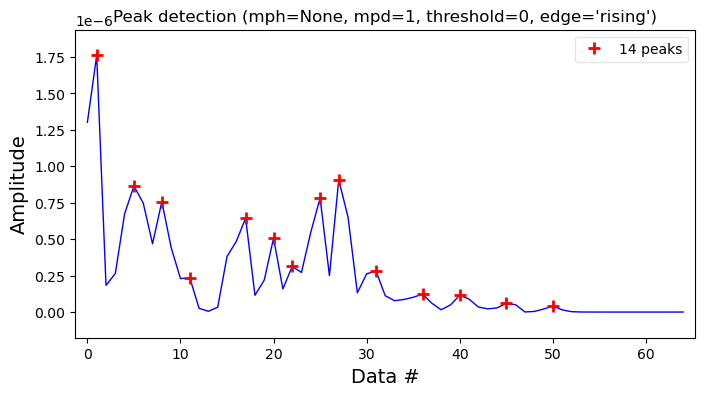

In [13]:
ind = detect_peaks(psd_values,show=True);

### Autocorrelation 

In [14]:
def autocorr(x): 
    """Compute the autocorrelation of discrete signal by means of the convolution 
    of the signal with its inverse. so the time difference goes from (-N+1,N-1) where N is 
    the number samples in the signal.

        args:
            x: the sampled values of the signal
        
    """
    result = np.correlate(x,x,mode = "full") 
    return result[len(result)//2:] # correlation of the signal in the positive time difference 

In [15]:
def get_autocorr_values(signal,T, N, f_s):
    """ Compute the autocorrelation of discrete signal and the corresponding time differences  

        args: 
            signal: sampled values of the signal
            T: sampling interval 
            N: number of samples
            f_s: sampling frequency  

        return: 
            dt_values: the time differences values 
            autocorr_values: the autocorrelation of the discrete signal over the time differences
              
    """
    autocorr_values = autocorr(signal)
    dt_values = np.array([T * i for i in range(N)])
    return dt_values, autocorr_values 

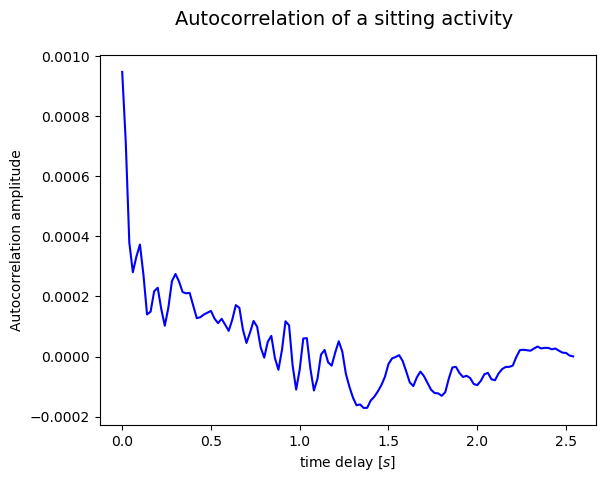

In [16]:
dt_values, autocorr_values = get_autocorr_values(signal, T, N, f_s)
 
plt.plot(dt_values, autocorr_values, "-b")
plt.xlabel('time delay $[s]$')
plt.ylabel('Autocorrelation amplitude');
plt.title(f"Autocorrelation of a {activity_name} activity \n", fontsize=14);

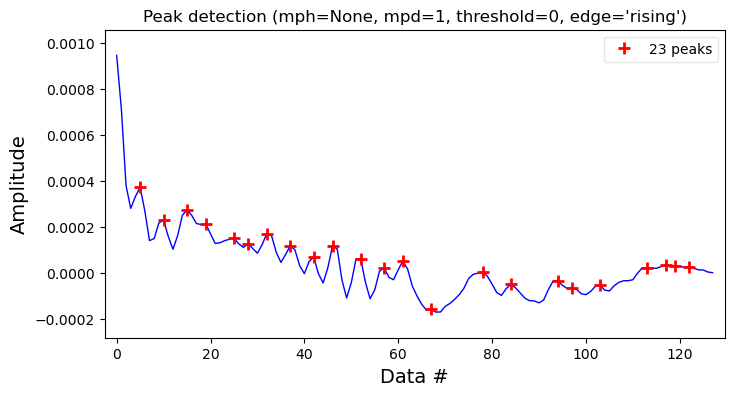

In [17]:
ind = detect_peaks(autocorr_values,show=True)

let's consider all transformations on all components 

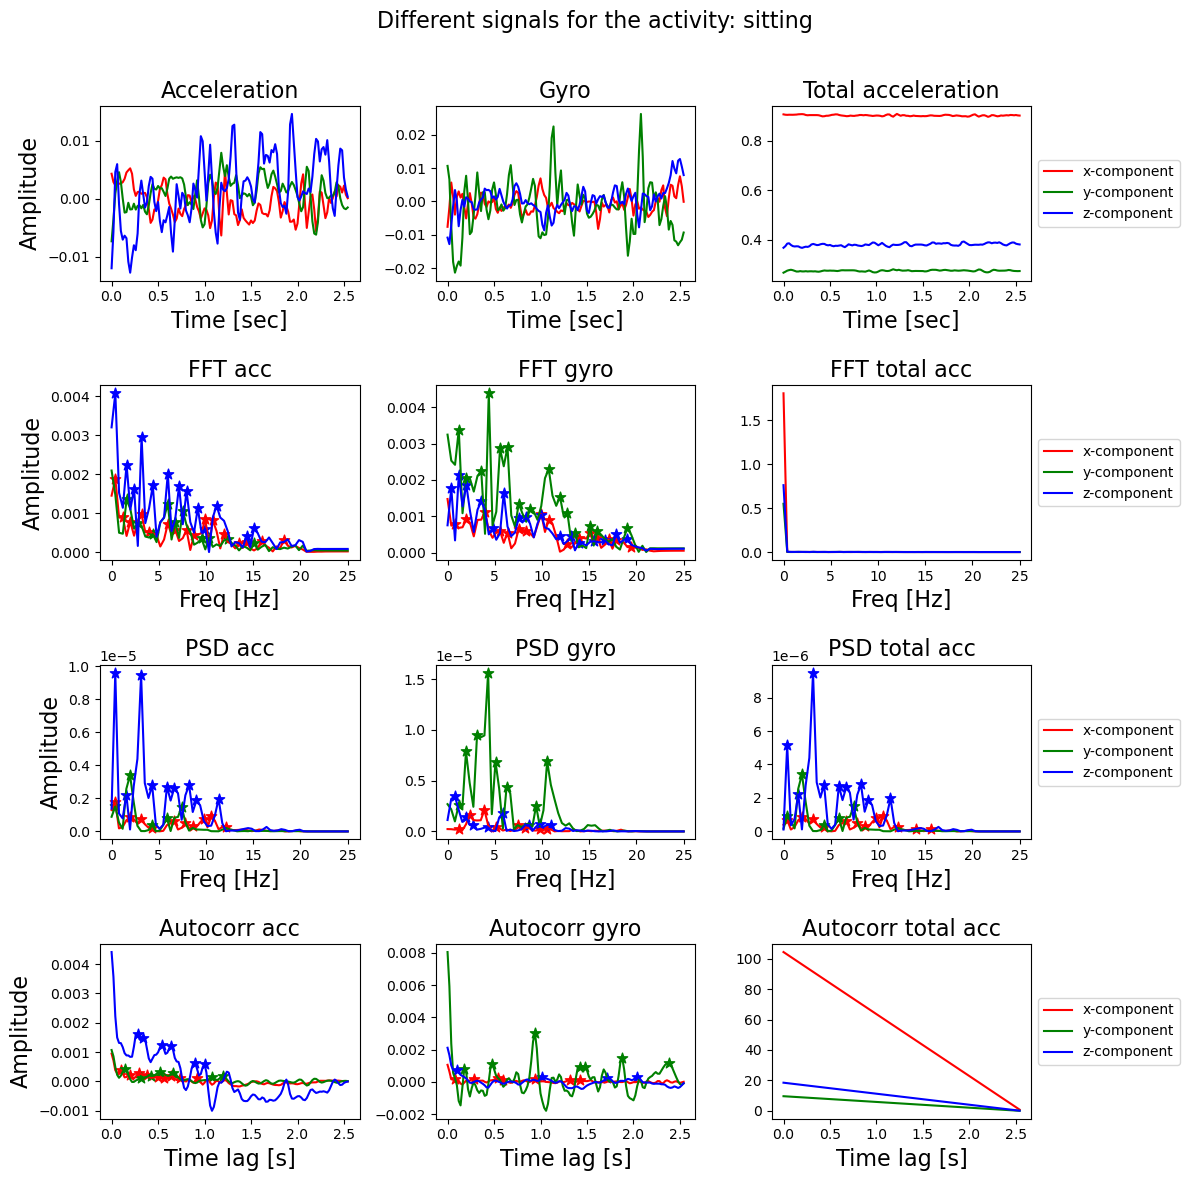

In [18]:
labels = ['x-component', 'y-component', 'z-component']
colors = ['r', 'g', 'b']
suptitle = f"Different signals for the activity: {activity_name}"
 
xlabels = ['Time [sec]', 'Freq [Hz]', 'Freq [Hz]', 'Time lag [s]']
ylabel = 'Amplitude'
axtitles = [['Acceleration', 'Gyro', 'Total acceleration'],
            ['FFT acc', 'FFT gyro', 'FFT total acc'],
            ['PSD acc', 'PSD gyro', 'PSD total acc'],
            ['Autocorr acc', 'Autocorr gyro', 'Autocorr total acc']
           ]
 
list_functions = [get_values, get_fft_values, get_psd_values, get_autocorr_values]

f, axarr = plt.subplots(nrows=4, ncols=3, figsize=(12,12))
f.suptitle(suptitle, fontsize=16)
 
for row_no in range(0,4):
    for comp_no in range(0,9):
        col_no = comp_no // 3 # (0,1,2) 0, (3,4,5) 1, (6,,7,8) 2
        plot_no = comp_no % 3 # (0,1,2) --> (x,y,z)
        color = colors[plot_no]
        label = labels[plot_no]
 
        axtitle  = axtitles[row_no][col_no]
        xlabel = xlabels[row_no]
        value_retriever = list_functions[row_no]
 
        ax = axarr[row_no, col_no]
        ax.set_title(axtitle, fontsize=16)
        ax.set_xlabel(xlabel, fontsize=16)
        if col_no == 0:
            ax.set_ylabel(ylabel, fontsize=16)
 
        signal_component = signals[:, comp_no]
        x_values, y_values = value_retriever(signal_component, T, N, f_s)
        ax.plot(x_values, y_values, linestyle='-', color=color, label=label)
        if row_no > 0:
            max_peak_height = 0.1 * np.nanmax(y_values)
            indices_peaks = detect_peaks(y_values, mph=max_peak_height)
            ax.scatter(x_values[indices_peaks], y_values[indices_peaks], c=color, marker='*', s=60)
        if col_no == 2:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))            
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.6)

## Extracting features  

In [19]:
def get_first_n_peaks(x,y,no_peaks = 5): 
    """ Extract the first "n_peaks" peaks of the transformed signal. If the number of peaks
        is not sufficient it fills the rest with zeros. 
        
        args:
            x: the x-coordinate of the transformed signal (time difference or frequency)
            y: the transformed signal values
            n_peaks: the number of peaks to extract from the signal
    """
    x_,y_ = list(x),list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks],y_[:no_peaks]
    else: # filling the rest values with zeros if it's not sufficient
        missing_no_peaks = no_peaks - len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks

In [20]:
def get_features(x_values,signal,mph): 
    """ extract some peaks from a transformed data at features.
            args:
                x_values: x-coordinate of the signal (i.e.,time difference & frequency)
                y_values: the transformed data (FFT, PSD or Autocorrelation values) 
                mph: the minimum peak height 
            
            return: 
                (peaks_x + peaks_y): a list of x and y coordinates concatenated 
    """
    indices_peaks = detect_peaks(signal,mph = mph) 
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks],signal[indices_peaks])
    return peaks_x + peaks_y 

The `train_signals` are of shape (7352,128,9). Below is the implementation of `extract_features_labels()` function which takes this matrix and originate a new matrix of (7352,270). The number of 270 column in this matrix equals the number of features extracted from each signal including including all components concatenated, where from each component we extract $(5 \times 2 \times 3)$. $5$ refers to the number of peaks from each transformation, 2 refers to the $x$ and $y$ coordinates for each peak and $3$ refers to the number of transformations considered. So, in total there are $(9 \times 3 \times 5 \times 2) = 270$ features 

In [21]:
def extract_features_labels(dataset, T, N, f_s,denominator):
    """ Extract the features from the components of each signal and concatenate them together. 

        args: 
            dataset: 3d-ndarray consisting of the components of each signal
            T: sampling interval 
            N: number of samples
            f_s: sampling frequency 
            denominator: controller of mph parameter of the detect_peaks() as function of the signal values 
    """
    percentile = 5 
    list_of_features = list()
    for signal_no in range(len(dataset)): # iterate over each signal 
        features = list()
        for signal_comp in range(dataset.shape[2]): # iterate over each component
            signal = dataset[signal_no,:,signal_comp] 

            # technique of controlling the mph as a function of the signal values
            signal_min = np.percentile(signal,percentile)            
            signal_max = np.percentile(signal,100 - percentile)
            mph = signal_min + (signal_max - signal_min)/denominator
            

            features += get_features(*get_fft_values(signal,T,N,f_s),mph)
            features += get_features(*get_psd_values(signal,T,N,f_s),mph)
            features += get_features(*get_autocorr_values(signal,T,N,f_s),mph)
        list_of_features.append(features)
    return np.array(list_of_features)

In [22]:
denominator = 10  
X_train = extract_features_labels(train_signals, T, N, f_s, denominator)
X_test = extract_features_labels(test_signals, T, N, f_s, denominator)

In [23]:
clf = RandomForestClassifier(random_state=1)
clf.fit(X_train, train_labels)
print(f"Accuracy on training set is : {clf.score(X_train, train_labels)}")
print(f"Accuracy on test set is : {clf.score(X_test, test_labels)}")
Y_test_pred = clf.predict(X_test)
accuracy_score(test_labels, Y_test_pred)

Accuracy on training set is : 1.0
Accuracy on test set is : 0.8788598574821853


0.8788598574821853

## Random Forest from Scratch 

### Weighted Gini Index Cost Function  

$$G(K) = (1 - \sum_{i \in N}{} P^{2}_{i,K}) \times F$$
* $G(k)$ is the Gini score of that Group $K$.
* $N$ is the number of classes.
* $P_{i,k}$ is the probability of group $K$ having class $i$.
* $F = \frac{Group\:size}{Total\: samples}$
  
A Gini score gives an idea of how good a split is by how mixed the classes are in the two groups created by the split. A perfect separation results in a Gini score of 0, whereas the worst case split that results in equal number of classes in each group result in a Gini score of $\frac{5}{6}$ (for a 6 class problem).



In [24]:
def gini_index(groups,classes):
    """Compute Gini index (split cost) for the groups resulting given the classes.

        args:
            groups (list or nd-array): contains the 2 groups resulting from the split
            classes (list or nd-array): contains the classes values exists in these groups

        return: 
            gini (float): the cost resulting from such split

    """
    # count number of samples at that split point 
    n_instances = sum([len(group) for group in groups])
    gini = 0
    for group in groups:
        size = len(group)
        if size == 0:
            continue
        score = 0 
        # score the group based on the score of each class.
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size 
            score += p * p 
        gini += (1-score) * (size/n_instances)

    return gini   

In [25]:
# testing 
print(f"The worst case results in: {gini_index([[[1, 1], [1, 0],[1, 2], [1, 3],[1,4],[1,5]], [[1, 1], [1, 0],[1, 2], [1, 3],[1,4],[1,5]]], [0,1,2,3,4,5])}") 
print(f"The lowest cost possible: {gini_index([[[1, 0], [1, 0]], [[1, 1], [1, 1]]], [0,1,2,3,4,5])}") 

The worst case results in: 0.8333333333333333
The lowest cost possible: 0.0


### Creating a Split 

**Simply put**, a split is comprised of an attribute in the dataset and a value.

Creating a split involves 3 parts, the first we have already looked at which is calculating the Gini Score, the remaining 2 are: 
1. Splitting a Dataset 
2. Evaluating All Splits. 

#### Splitting a Dataset 

Splitting a dataset means separating the dataset into to lists of rows given index of an attribute and a split value for that attribute. 
Once we have the two groups, we can then use the `gini_index()` to evaluate the Gini score (cost) of that split.    
 \
**Splitting a dataset involves iterating over each row, checking if the attribute value is below or above the split value and assigning it to the left or right group respectively.**  
 \
Below is the function `test_split()` which implements this procedure.

In [26]:
def test_split(index, value, dataset):
    left, right = list(),list()
    for row in dataset: 
        curr_val = row[index] 
        if curr_val < value:
            left.append(row)
        else: # > or ==
            right.append(row)
    return left, right 

#### Evaluating All Splits

Before getting into implementation details, i need to point out to how the random forest actually works. Random forests introduces two types of randomness to decision trees: 

1. The first type has to do with introducing randomness to the data, so that each tree is fit to a somewhat different dataset.  
  
2. The second type of randomness has to do with which predictors are considered when making a split at any point in a given tree.

**These two steps have the implication of decorrelating the trees, which ultimately gives us a more reliable method.**

*First Type (Bootstrap Aggregation or Bagging)* 
- In the context of decision trees, means that we draw a number of bootstrap datasets and fit each to a tree. So, If we have n observations in our training data set,we form a bootstrap dataset by randomly selecting n observations **with replacement** from the original dataset.

*Second Type*
- Normally with decision trees we consider each predictor in the predictor space when making a cut into the predictor space. In contrast, in random forest, each time we consider a split, we don't look at all predictors, but instead draw a small random sample of the predictors. Each time we make a split, we take a new sample of predictors.

Below is a function named `get_split()` that implements this procedure. It takes a dataset and a fixed number of input features as input arguments, where the dataset may be a sample of the actual training dataset. \
 \
The helper function `test_split()` is used to split the dataset by a candidate split point adn `gini_index()`is used to evaluate the cost of a given split by the groups of rows created. \
 \
We will use a dictionary to represent a node in the decision tree as we can store data by name. When selecting the best split and using it as a new node for the tree we will store the index of the chosen attribute, the value of that attribute by which to split and the two groups of data split by the chosen split point; this will be clear in the implementation details below

In [27]:
def get_split(bootstrap, n_feratures):
    class_val = list(set([row[-1] for row in bootstrap]))
    b_index, b_value,b_score,b_groups = 999,999,999,None # this values will be adjusted later
    features = list() 
    while len(features) < n_feratures:
        index = np.random.randint(len(bootstrap[0])-1) # the last column is the label 
        if index not in features:
            features.append(index)
    for index in features: 
        for row in bootstrap:
            groups = test_split(index,row[index],bootstrap)
            score = gini_index(groups,class_val)
            if score < b_score:
                b_index, b_value,b_score,b_groups = index,row[index],score,groups
    return {"index":b_index,"value":b_value,"groups":b_groups}

### Building a Single Decision Tree 

Creating the root node of the tree is easy. We  call the above `get_split()` function using the entire dataset. Adding more nodes to our tree is more interesting.  
 \
Building a Tree may be divided into 3 main parts:
1. Terminal Nodes.
2. Recursive Splitting.
3. Building a Tree.



#### Terminal Nodes 
We need to decide when to stop growing a tree. We can do that using **the depth and the number of rows that the node is responsible for in the training dataset**
* **Maximum Tree Depth**: This is the maximum number of nodes from the root node of the tree. Once a maximum depth of the tree is met, we must stop splitting and adding new nodes. **Deeper trees are more complex and are more likely to overfit the training data**    

* **Minimum Node Records**: This is the minimum number of training patterns that a given node is responsible for. Once at or below this minimum, we must stop splitting and adding new nodes. **Nodes that account for too few training patterns are expected to be too specific and are likely to overfit the training data.**  

These two approaches will be user-specified arguments to our tree building procedure. 

There is one more condition. It's possible to choose a split in which all rows belong to one group. In this case, we will be unable to continue splitting and adding child nodes as we will have no records to split on one side or another. 
(the final decision will always belong to that group) 

When we do stop growing at a given point, that node is called a terminal node and is used to make a final prediction. 

Below is a function `to_terminal()` that will select a class value for a group of rows. It returns the most common output value in a list of rows.

In [28]:
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes),key = outcomes.count) 

#### Recursive Splitting 

*Remember that we are using Dictionary representation of nodes in trees* 

Below is a function `split()` that implements this recursive splitting procedure. It takes a node as an argument as well as the maximum depth, minimum number of patterns in a node, the current depth of a node and the number of features considered in building each decision tree. 

>**Depth of Tree** is the total number of edges from the root node to the leaf node in the longest path.

You can imagine how this might be first called passing in the root node and the depth of 1. This function is best explained in steps:
1. Firstly, the two groups of data split by the node are extracted for use and deleted from the node. As we work on these groups the node no longer requires access to these data. 
2. Next, we check if either left or right group of rows is empty and if so we create a terminal node using what records we do have. 
3. We then check if we have reached out maximum depth and if so we create terminal node.
4. We then process the left child, creating a terminal node if the group of rows is too small or if all the rows belongs to the same class, otherwise creating and adding the left node in a depth first fashion until the bottom of the tree is reached on this branch.  
  
5. the right side is then processed in the same manner, as we rise back up the constructed tree to the root.



In [29]:
def split(node,max_depth,min_size,n_features,depth = 1):
    left, right = node["groups"] 
    del(node["groups"])
    # check for no split 
    if not left or not right:
        node["left"] = node["right"] = to_terminal(left+right) # i don't care which is empty
        return 
    # check for max depth 
    if depth >= max_depth:
        node["left"],node["right"] = to_terminal(left), to_terminal(right)
        return 
    # process the left child 
    if len(left) <= min_size:
        node["left"] = to_terminal(left)
    elif len(set([row[-1] for row in left])) == 1: # to avoid unnecessary splits
        node["left"] = to_terminal(left)
    else:
        node["left"] = get_split(left,n_features)
        split(node["left"],max_depth,min_size,n_features,depth+1)
    # process the right child 
    if len(right) <= min_size:
        node["right"] = to_terminal(right)
    elif len(set([row[-1] for row in right])) == 1:  # to avoid unnecessary splits
        node["right"] = to_terminal(right)
    else:
        node["right"] = get_split(right,n_features)
        split(node["right"],max_depth,min_size,n_features,depth+1)


#### Building a Decision Tree

Building the tree involves creating the root node using `get_split()` function and then calling the `split()` function that then calls itself recursively to build out the whole tree.

Below is the small `build_tree()` function that implements this procedure.

In [30]:
def build_tree(dataset,max_depth,min_size,n_features):
    root = get_split(dataset,n_features)
    split(root,max_depth,min_size,n_features)
    return root

### Making Prediction

Making predictions with a decision tree involves navigating the tree with the specifically provided row of data. \
 \
We can implement this using a recursive function, where the same prediction routine is called again with the left or the right child nodes, depending on how the split affects the provided data. \
 \
We must check if a child node is either a terminal value to be returned as the prediction, or if it is a dictionary node containing another level of the tree to be considered. \
 \
Below is the `predict()` function that implements this procedure.


In [31]:
def predict(root,row):
    if row[root["index"]] < root["value"]: # check which path to take (left)
        if isinstance(root["left"],dict): # check whether it's a terminal node or not
            return predict(root["left"],row)
        else:
            return root["left"]
    else:
        if isinstance(root["right"],dict):
            return predict(root["right"],row)
        else:
            return root["right"]

In random forest, we need to consider the predictions of multiple decision trees trained on different sub-samples of the dataset with replacement. 

Below is the implementation of `subsample()` function which samples the dataset for building single decision tree. 


In [32]:
def subsample(dataset,ratio): # the ratio is fraction of dataset taken for building the tree
    sample = list() 
    sample_size = round(len(dataset) * ratio)
    while len(sample) < sample_size:
        index = np.random.randint(len(dataset)) 
        sample.append(dataset[index]) # replacement is considered 
    return sample 

the `build_random_forest()` function considers building multiple relatively uncorrelated decision trees to construct the promising forest.

In [33]:
def build_random_forest(train,max_depth,min_size,sample_ratio,n_trees,n_features):
    trees = list() 
    for i in range(n_trees):
        sample = subsample(train,sample_ratio)
        tree = build_tree(sample,max_depth,min_size,n_features)
        trees.append(tree)
    return trees

In [34]:
# predicting for single signal using multiple decision tress
def bagging_predict(trees,row):
    predictions = [predict(tree,row) for tree in trees]
    return max(set(predictions),key = predictions.count) 

In [35]:
# predicting for a set of signals 
def random_forest_predict(model,test):
    predictions = [bagging_predict(model,row) for row in test]
    return predictions

### Applying the Model to our Problem 

In [36]:
# X_train = X_train_reduced[:,:100]
# X_test = X_test_reduced[:,:100]

In [37]:
# appending the features and labels of training data as considered by the model 
final_dataset = np.hstack([X_train,train_labels.reshape(-1,1)])
print(final_dataset.shape)

(7352, 271)


In [38]:
np.random.seed(1)
max_depth = 20
min_size = 1
sample_ratio = 0.5
n_features = int(np.sqrt(len(final_dataset[0])-1))
n_trees =  20
model = build_random_forest(final_dataset,max_depth,min_size,sample_ratio,n_trees,n_features)

In [39]:
predictions = random_forest_predict(model,X_test)
print(f"The accuracy of the model: {100*accuracy_score(test_labels,predictions):.2f} %")

The accuracy of the model: 86.43 %
